In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU'),tf.config.list_physical_devices('CPU')

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')])

In [2]:
import data_preprocess_functions as dp_f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA, KernelPCA

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#columns_list=['trk_log_pt', 'trk_eta', 'theta', 'phi', 'log_dr', 'log_ptfrac']
columns_list=np.array(['trk_log_pt', 'trk_eta', 'Deta', 'phi', 'log_dr', 'log_ptfrac',
       'pZfrac', 'log_p3fracJetE', 'closestJetDeta',
       'log_closestJetDRtrkjet'])

In [4]:
mode='FixedCone/'

path='../PKL/Zprime'+mode+'singleBJet_0.2comp_isfromBoutDR==0/'

In [5]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dp_f.retrieve_dataset(path)

In [6]:
X_train.shape

(499879, 10)

In [7]:
pca = PCA(n_components=10)

In [8]:
pca.fit(X_train)
u=pca.components_#eigen_v
X_pca=pca.transform(X_train)

In [109]:
#np.savetxt(path+"pca_u.csv",u,delimiter=",")

In [110]:
###      NEED TO SAVE WEIGHTS U     ###

Explained variance ratio: [5.09233150e-01 1.75095675e-01 1.22085309e-01 7.13555608e-02
 4.90785553e-02 3.57095939e-02 2.00352582e-02 1.57285527e-02
 1.36231804e-03 3.16026887e-04]


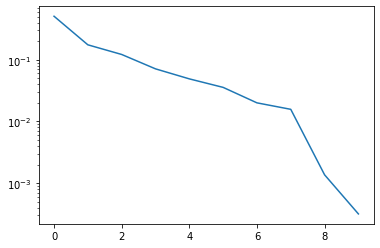

In [9]:
print('Explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')

In [10]:
def n(cut):
    k=0
    s=pca.explained_variance_ratio_[k]

    while s<cut:
        k=k+1
        s=s+pca.explained_variance_ratio_[k]
        
    return s,k+1

In [13]:
e=0.99
n_feats=n(e)[1]
print(n(e))

(0.9983216550725404, 8)


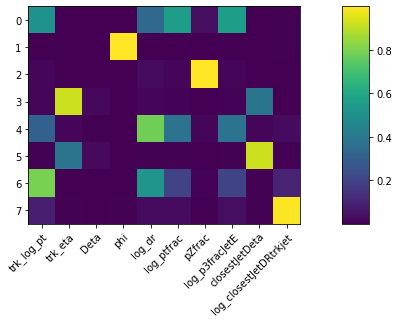

In [14]:
fig, ax = plt.subplots(1,figsize=(15,4))
im = ax.imshow(np.abs(u[:n_feats]))
ax.set_xticks(np.arange(len(columns_list)))
ax.set_xticklabels(columns_list)
ax.set_yticks(np.arange(n_feats))
ax.set_yticklabels(np.arange(n_feats))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, orientation='vertical', aspect=8)
plt.show()

In [116]:
def z(x):
#    return np.concatenate((u_1@x,u_0@x)).astype('float32')
    return u@x

def z_v(X):
    zv_m=z(X[0,:])
    for i in range(1,X.shape[0]):
        zv_m=np.vstack( (zv_m,z(X[i,:])) )
        
        print(float(i/X.shape[0]),end='')
        print('\r', end='')  
    
    print('Done',end='')
#    print('\r', end='')
        
    return zv_m

In [117]:
z_train=z_v(X_train)

0.1550597234806305

Done999769451918044

In [118]:
z_test=z_v(X_test)

Done999077814050434

In [119]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler().fit(z_train)
z_train_scaled=scaler_train.transform(z_train)
z_test_scaled=scaler_train.transform(z_test)

In [124]:
f=4
print(np.mean(z_train_scaled[:,f]),np.std(z_train_scaled[:,f]))
print(np.mean(z_test_scaled[:,f]),np.std(z_test_scaled[:,f]))

1.115381842977871e-14 1.0000000000000009
-0.0018279505419501682 1.004298508988049


In [125]:
np.savetxt(path+"z_train.csv",z_train,delimiter=",")
np.savetxt(path+"z_test.csv",z_test,delimiter=",")
np.savetxt(path+"z_train_scaled.csv",z_train_scaled,delimiter=",")
np.savetxt(path+"z_test_scaled.csv",z_test_scaled,delimiter=",")

In [6]:
#z_train_scaled=np.genfromtxt(path+"z_train_scaled.csv",delimiter=",")
#z_test_scaled=np.genfromtxt(path+"z_test_scaled.csv",delimiter=",")

In [126]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_sig_bkg(X,y,columns_list,density_f,mode,path):
    fig=plt.figure(figsize=(16,12))
    gs = gridspec.GridSpec(nrows=3, ncols=3, width_ratios=[1,1,1],figure=fig)
#    fig.suptitle('No cut')

    for i in range(0,len(columns_list)):
        ax=fig.add_subplot(gs[i])
        im = ax.hist(X[np.where(y==0),i][0],bins=100,alpha=0.5,density=density_f,label='bkg')
        im = ax.hist(X[np.where(y==1),i][0],bins=100,alpha=0.5,density=density_f,label='signal')
        ax.set_xlabel(columns_list[i])
        if mode=='log':
            ax.set_yscale('log')
        ax.legend()

    plt.savefig(path+'PCA_vars_sig_bkg'+mode+'.pdf')
    plt.show()

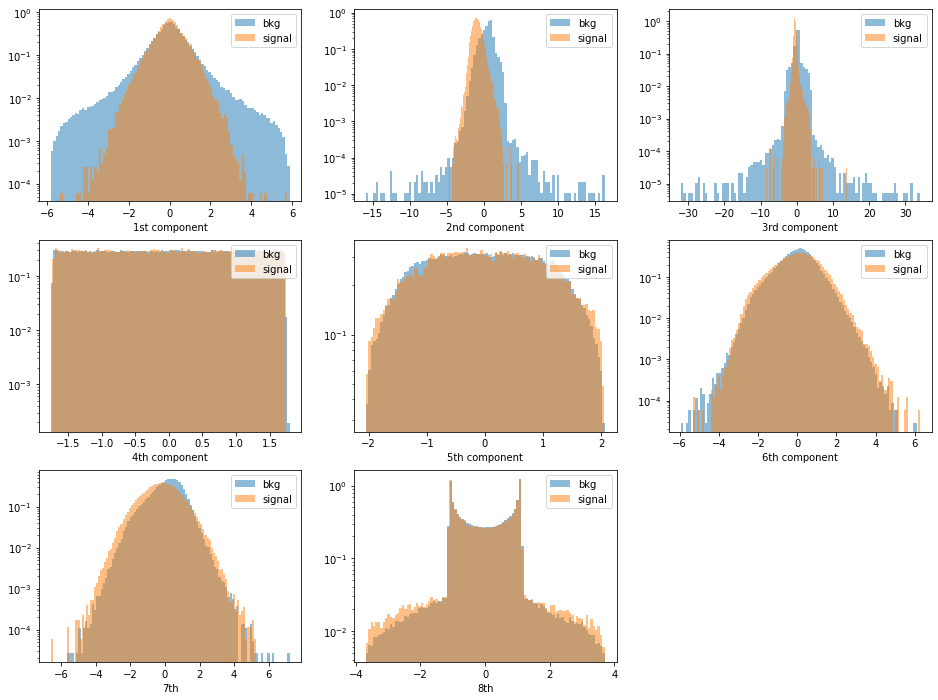

In [127]:
plot_sig_bkg(z_train_scaled,y_train,['1st component','2nd component','3rd component','4th component','5th component','6th component','7th','8th'],True,'log',path)

In [143]:
n_c=32
device='gpu'

with tf.device("/gpu:0"):
    NN = models.Sequential()
    NN.add(layers.Dense(2*n_c, activation=tf.nn.relu))
#    NN.add(layers.Dense(2*n_c, activation=tf.nn.relu))
    NN.add(layers.Dense(2*n_c, activation=tf.nn.sigmoid))
    NN.add(layers.Dense(n_c, activation=tf.nn.relu))
#    NN.add(layers.Dense(2*n_c, activation=tf.nn.relu))
    NN.add(layers.Dense(n_c, activation=tf.nn.sigmoid))    
    NN.add(layers.Dense(2, activation=tf.nn.softmax, name='preds'))

    NN.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics = ['accuracy'])



Epoch 1/10
13555/13555 [==============================] - 16s 1ms/step - loss: 0.2961 - accuracy: 0.8733
Epoch 2/10
13555/13555 [==============================] - 16s 1ms/step - loss: 0.2528 - accuracy: 0.8980
Epoch 3/10
13555/13555 [==============================] - 16s 1ms/step - loss: 0.2425 - accuracy: 0.9029
Epoch 4/10
13555/13555 [==============================] - 16s 1ms/step - loss: 0.2401 - accuracy: 0.9040
Epoch 5/10
13555/13555 [==============================] - 15s 1ms/step - loss: 0.2390 - accuracy: 0.9039
Epoch 6/10
13555/13555 [==============================] - 16s 1ms/step - loss: 0.2404 - accuracy: 0.9040
Epoch 7/10
13555/13555 [==============================] - 15s 1ms/step - loss: 0.2384 - accuracy: 0.9038
Epoch 8/10
13555/13555 [==============================] - 15s 1ms/step - loss: 0.2368 - accuracy: 0.9056
Epoch 9/10
13555/13555 [==============================] - 15s 1ms/step - loss: 0.2371 - accuracy: 0.9055
Epoch 10/10
13555/13555 [==============================

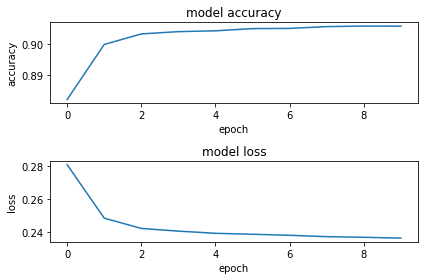

In [144]:
history=NN.fit(z_train_scaled, y_train_cat, batch_size=32, epochs=10, verbose=1)

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xscale('log')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.xscale('log')

plt.tight_layout()
fig

print('accuracy:', history.history['accuracy'][-1], 'loss:', history.history['loss'][-1])

#print('Evaluation on training set')
#NN.evaluate(X_train_scaled, y_train_cat)
#print('Evaluation on test set')
#NN.evaluate(X_test_scaled, y_test_cat)


In [ ]:
print('Evaluation on test set 0')
NN.evaluate(z_test_scaled[y_test==0], y_test_cat[y_test==0])
print('Evaluation on test set 1')
NN.evaluate(z_test_scaled[y_test==1], y_test_cat[y_test==1])


Evaluation on test set 0
2262/2262 [==============================] - 2s 843us/step - loss: 0.1971 - accuracy: 0.9129
Evaluation on test set 1
 242/1128 [=====>........................] - ETA: 0s - loss: 0.3198 - accuracy: 0.8949

In [137]:
model_name='PCANN_base'
NN.save(path+'models/'+model_name+'/')

INFO:tensorflow:Assets written to: ../PKL/ZprimeFixedCone/singleBJet_0.5comp_isfromBoutDR==0_IPvars/models/PCANN_base/assets


INFO:tensorflow:Assets written to: ../PKL/ZprimeFixedCone/singleBJet_0.5comp_isfromBoutDR==0_IPvars/models/PCANN_base/assets


In [138]:
import ROC as roc_maker

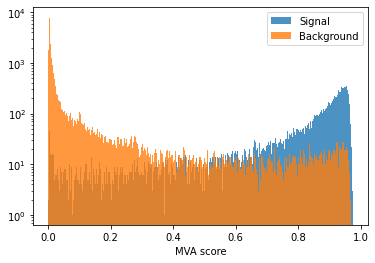

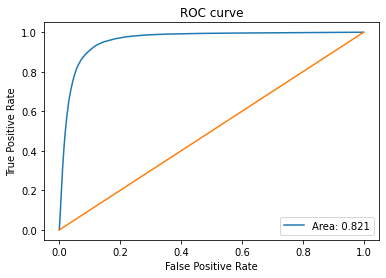

/home/salomongpu/Private/TrackAssociator/v3/scripts/ROC.py:66: RuntimeWarning: divide by zero encountered in true_divide
  rej=1./noise_eff


['10.7', '7.7', '5.2', '3.0']


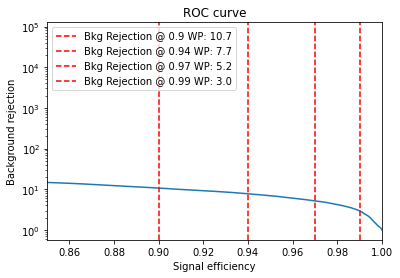

In [139]:
ROC_PCANN_TA=roc_maker.ROC(NN,z_test_scaled,y_test,'PCANN_base')